In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss, PULossWrapped#, PURankingLoss
from data_loader import *
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
dataset = Epilepsy2Dataset()
X, y = dataset.data.numpy(), dataset.labels.numpy()
X.shape

(11500, 178)

In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, stratify=y_train_val, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (8050, 178) (8050,)
Validation: (1150, 178) (1150,)
Test: (2300, 178) (2300,)


In [4]:
positive_class=1
unlabeled_fraction = 0.5

In [5]:
y_train_pu, unlabeled_idx_train = make_pu_labels(y_train, positive_class=positive_class, unlabeled_fraction=unlabeled_fraction)
y_val_pu, unlabeled_idx_val = make_pu_labels(y_val, positive_class=positive_class, unlabeled_fraction=unlabeled_fraction)
y_test_pu, unlabeled_idx_test = make_pu_labels(y_test, positive_class=positive_class, unlabeled_fraction=unlabeled_fraction)
print((y_train[y_train == 1]).shape)
print((y_train_pu[y_train_pu == 1]).shape)
print((y_val[y_val == 1]).shape)
print((y_val_pu[y_val_pu == 1]).shape)
print((y_test[y_test == 1]).shape)
print((y_test_pu[y_test_pu == 1]).shape)

(1610,)
(805,)
(230,)
(115,)
(460,)
(230,)


In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_pu_tensor = torch.tensor(y_train_pu, dtype=torch.long)
y_test_pu_tensor = torch.tensor(y_test_pu, dtype=torch.long)
y_val_pu_tensor = torch.tensor(y_val_pu, dtype=torch.long)

## InceptionTime + AsymLoss

In [7]:
from pu_loss import PUAsymLoss_Direct, PUAsymLoss_CE

In [10]:
logits = torch.tensor((
  [ +0.496714, -0.138264 ],
  [ +0.647689, +1.523030 ],
  [ -0.234153, -0.234137 ],
  [ +1.579213, +0.767435 ],
  [ -0.469474, +0.542560 ],
  [ -0.463418, -0.465730 ],
  [ +0.241962, -1.913280 ],
  [ -1.724918, -0.562288 ],
  [ -1.012831, +0.314247 ],
  [ -0.908024, -1.412304 ]))
y_true = torch.tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.long)


In [11]:
loss_fn = PUAsymLoss_Direct(gamma=0.8) 
loss2_fn = PUAsymLoss_CE(gamma=0.8)


In [12]:
print(loss_fn(logits, y_true))
print(loss2_fn(logits, y_true))

tensor(-0.7997)
tensor(-0.7997)


In [8]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.tracker import SaveModelCallback

# Try PU problem with CrossEntropyLoss

from sklearn.metrics import f1_score, precision_score
from tsai.metrics import skm_to_fastai

f1_macro = skm_to_fastai(f1_score, average="macro")
precision_macro = skm_to_fastai(precision_score, average="macro")

criterion = PUAsymLoss_CE(gamma=0.9)

X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
         list(range(len(y_train_pu), len(y_all))))



tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=[accuracy, precision_macro, f1_macro], cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,train_precision_score,train_f1_score,valid_loss,valid_accuracy,valid_precision_score,valid_f1_score,time
0,-2.029514,0.134125,0.551709,0.130380,-2.193935,0.623478,0.673454,0.603685,00:02
1,-2.220221,0.670500,0.616227,0.576693,-2.257826,0.860000,0.794118,0.822425,00:02
2,-2.251842,0.710625,0.628111,0.608292,-2.260962,0.782609,0.739583,0.745327,00:02
3,-2.243772,0.747875,0.641603,0.639453,-2.104274,0.956522,0.923524,0.933773,00:02
4,-2.253809,0.740750,0.639130,0.633615,-2.259881,0.916522,0.852790,0.885866,00:02
5,-2.265060,0.763750,0.648882,0.653973,-2.261563,0.937391,0.882017,0.911027,00:02
6,-2.268870,0.770750,0.651825,0.659990,-2.268069,0.795652,0.747312,0.757727,00:02
7,-2.272774,0.800250,0.666766,0.687744,-2.272252,0.920000,0.857289,0.889803,00:02
8,-2.273486,0.805875,0.669401,0.692696,-2.279518,0.907826,0.842202,0.875498,00:02
9,-2.277807,0.823375,0.680601,0.710968,-2.284573,0.928696,0.868760,0.900779,00:02


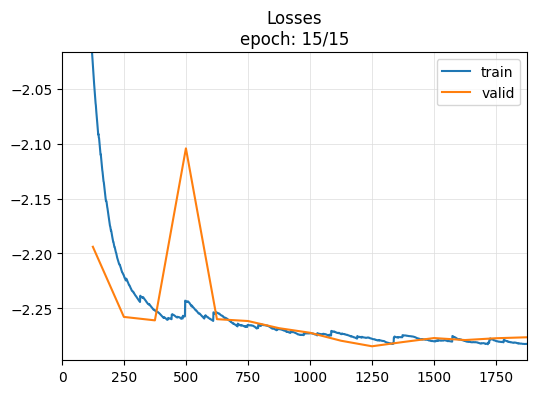

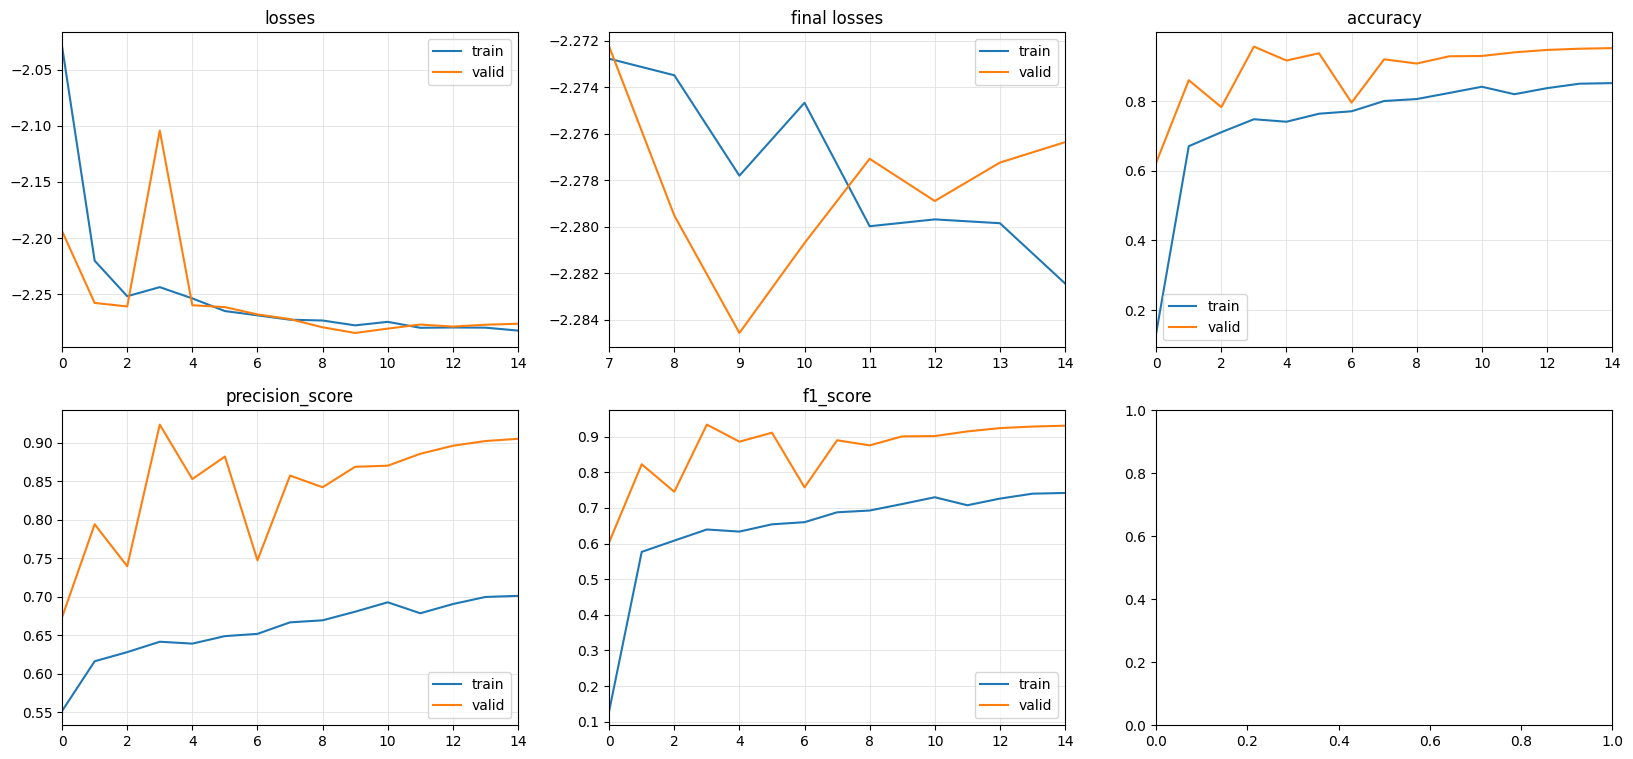

In [112]:
clf.fit_one_cycle(15, 1e-4)

In [9]:
clf.load("epilepsy_inctime_asymloss_gamma_0.1")

In [10]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape

(9200, 1, 178)

In [11]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9998    0.8907    0.9421      7245
           1     0.5038    0.9988    0.6697       805

    accuracy                         0.9015      8050
   macro avg     0.7518    0.9447    0.8059      8050
weighted avg     0.9502    0.9015    0.9149      8050

[[6453  792]
 [   1  804]]


In [12]:
probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9870    0.9891    0.9881      6440
           1     0.9561    0.9478    0.9520      1610

    accuracy                         0.9809      8050
   macro avg     0.9716    0.9685    0.9700      8050
weighted avg     0.9808    0.9809    0.9808      8050

[[6370   70]
 [  84 1526]]


In [13]:
# Val metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = probas.argmax(dim=-1)
print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9946    0.8879    0.9382      1035
           1     0.4867    0.9565    0.6452       115

    accuracy                         0.8948      1150
   macro avg     0.7407    0.9222    0.7917      1150
weighted avg     0.9438    0.8948    0.9089      1150

[[919 116]
 [  5 110]]


In [14]:
# Val metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = probas.argmax(dim=-1)
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9881    0.9924    0.9902       920
           1     0.9690    0.9522    0.9605       230

    accuracy                         0.9843      1150
   macro avg     0.9786    0.9723    0.9754      1150
weighted avg     0.9843    0.9843    0.9843      1150

[[913   7]
 [ 11 219]]


In [15]:
# Test metrics
probas, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test_pu, with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9940    0.8821    0.9347      2070
           1     0.4730    0.9522    0.6320       230

    accuracy                         0.8891      2300
   macro avg     0.7335    0.9171    0.7834      2300
weighted avg     0.9419    0.8891    0.9045      2300

[[1826  244]
 [  11  219]]


In [16]:
probas, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test_pu, with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9886    0.9870    0.9878      1840
           1     0.9482    0.9543    0.9512       460

    accuracy                         0.9804      2300
   macro avg     0.9684    0.9707    0.9695      2300
weighted avg     0.9805    0.9804    0.9805      2300

[[1816   24]
 [  21  439]]


In [17]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 722
In percentage: 0.8969
Test
Total number of true positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 220
In percentage: 0.9565
Val
Total number of true positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 109
In percentage: 0.9478


In [ ]:
# Best precision for a threshold at f1 >= f1_fixed

y_true = y_val
probs = F.softmax(probas, dim=1)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
ap = average_precision_score(y_true, probs)
print(f"Average Precision: {ap:.4f}")

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# 1. Choose the "fixed F1" you want (e.g., max F1)
y_pred_05 = (probs >= 0.5).numpy().astype(int)
fixed_f1 = f1_score(y_true, y_pred_05)
print(f"F1 at threshold 0.5: {fixed_f1:.4f}")

# 2️. Find all thresholds with F1 >= fixed_f1
candidate_idxs = (f1_scores >= fixed_f1).nonzero()[0]

# 3️. Pick the threshold among them that maximizes precision
best_idx = candidate_idxs[precisions[candidate_idxs].argmax()]
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # safety
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Fixed F1 >= {fixed_f1:.4f}:")
print(f"Threshold = {best_threshold:.4f}, Precision = {best_precision:.4f}, F1 = {best_f1:.4f}, Recall = {best_recall:.4f}")


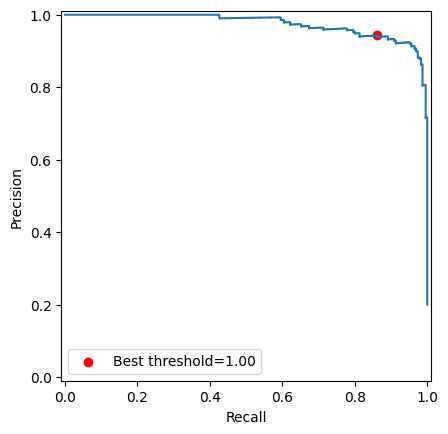

In [124]:
disp = PrecisionRecallDisplay(precision=precisions, recall=recalls)
disp.plot()
plt.scatter(best_recall, best_precision, color='red', label=f'Best threshold={best_threshold:.2f}')
plt.legend()
plt.show()

In [127]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels with max precision.
y_true = y_test
probs = F.softmax(probas, dim=1)[:, 1]
y_pred_prec_fixed = (probs >= best_threshold).numpy().astype(int)
print("Test")
correct_preds_num_tst = (y_pred_prec_fixed[unlabeled_idx_test] == y_true[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_true==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print(confusion_matrix(y_true, y_pred_prec_fixed))
print(f"Best precision: {best_precision:.4f}")

Test
Total number of positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 202
In percentage: 0.8783
[[1822   18]
 [  60  400]]
Best precision: 0.9429


In [128]:
clf.save("epilepsy_inctime_asymloss_gamma_0.9")

Path('models/epilepsy_inctime_asymloss_gamma_0.9.pth')

## Mamba2 Linear proj + Asym Loss

In [10]:
batch_size = 128
X_train_tensor = X_train_tensor.unsqueeze(1)
X_val_tensor = X_val_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([8050, 1, 178])


In [11]:
positive_prior = torch.tensor(y_train_pu.mean(), dtype=torch.float32)
positive_prior

tensor(0.1000)

In [12]:
in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_pu_tensor.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 178, n_output: 2


In [13]:
from baseline import Mamba2Classifier, train
from pu_loss import PUAsymLoss_CE
batch_size = 64
print(X_train_tensor.shape)

torch.Size([8050, 1, 178])


In [11]:
criterion = PUAsymLoss_CE(gamma=0.05)


In [102]:
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.3)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [78]:
model_mamba = train(model_mamba, criterion, train_loader, val_loader, 0.0001, 15, device)

100%|██████████| 63/63 [00:02<00:00, 26.72it/s]


Epoch [1/15], tr_loss: 0.68002 tr_acc: 0.85342 test_loss: 1.59492, test_acc: 0.89478


100%|██████████| 63/63 [00:02<00:00, 27.00it/s]


Epoch [2/15], tr_loss: 0.53934 tr_acc: 0.86422 test_loss: 0.24156, test_acc: 0.96174


100%|██████████| 63/63 [00:02<00:00, 26.96it/s]


Epoch [3/15], tr_loss: 0.51614 tr_acc: 0.86484 test_loss: 0.19692, test_acc: 0.95826


100%|██████████| 63/63 [00:02<00:00, 26.98it/s]


Epoch [4/15], tr_loss: 0.49785 tr_acc: 0.86571 test_loss: 0.19686, test_acc: 0.96087


100%|██████████| 63/63 [00:02<00:00, 27.04it/s]


Epoch [5/15], tr_loss: 0.48569 tr_acc: 0.86509 test_loss: 0.19316, test_acc: 0.96087


100%|██████████| 63/63 [00:02<00:00, 26.98it/s]


Epoch [6/15], tr_loss: 0.47999 tr_acc: 0.86559 test_loss: 0.22579, test_acc: 0.96348


100%|██████████| 63/63 [00:02<00:00, 27.01it/s]


Epoch [7/15], tr_loss: 0.47439 tr_acc: 0.86584 test_loss: 0.24917, test_acc: 0.96435


100%|██████████| 63/63 [00:02<00:00, 26.98it/s]


Epoch [8/15], tr_loss: 0.46628 tr_acc: 0.86609 test_loss: 0.24457, test_acc: 0.96435


100%|██████████| 63/63 [00:02<00:00, 27.01it/s]


Epoch [9/15], tr_loss: 0.45849 tr_acc: 0.86683 test_loss: 0.23680, test_acc: 0.96522


100%|██████████| 63/63 [00:02<00:00, 26.96it/s]


Epoch [10/15], tr_loss: 0.44994 tr_acc: 0.86745 test_loss: 0.23776, test_acc: 0.96696


100%|██████████| 63/63 [00:02<00:00, 26.98it/s]


Epoch [11/15], tr_loss: 0.44772 tr_acc: 0.86609 test_loss: 0.22695, test_acc: 0.96522


100%|██████████| 63/63 [00:02<00:00, 26.97it/s]


Epoch [12/15], tr_loss: 0.43990 tr_acc: 0.86708 test_loss: 0.21172, test_acc: 0.96609


100%|██████████| 63/63 [00:02<00:00, 26.96it/s]


Epoch [13/15], tr_loss: 0.43441 tr_acc: 0.86882 test_loss: 0.20565, test_acc: 0.96783


100%|██████████| 63/63 [00:02<00:00, 26.96it/s]


Epoch [14/15], tr_loss: 0.42858 tr_acc: 0.86870 test_loss: 0.21251, test_acc: 0.96696


100%|██████████| 63/63 [00:02<00:00, 26.97it/s]


Epoch [15/15], tr_loss: 0.42457 tr_acc: 0.86907 test_loss: 0.20401, test_acc: 0.96696


In [79]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([2300, 178, 1])
torch.Size([8050, 178, 1])


In [80]:
#Mamba2
# PU labels used during training where half of positives are unlabaled

preds_train = []
out_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        out_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9912    0.8745    0.9292      7245
           1     0.4517    0.9304    0.6082       805

    accuracy                         0.8801      8050
   macro avg     0.7215    0.9025    0.7687      8050
weighted avg     0.9373    0.8801    0.8971      8050

[[6336  909]
 [  56  749]]


In [81]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9772    0.9699    0.9735      6440
           1     0.8830    0.9093    0.8960      1610

    accuracy                         0.9578      8050
   macro avg     0.9301    0.9396    0.9347      8050
weighted avg     0.9583    0.9578    0.9580      8050

[[6246  194]
 [ 146 1464]]


In [82]:
preds_val = []
out_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        out_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
out_val = torch.cat(out_val)

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9902    0.8783    0.9309      1035
           1     0.4569    0.9217    0.6110       115

    accuracy                         0.8826      1150
   macro avg     0.7235    0.9000    0.7709      1150
weighted avg     0.9369    0.8826    0.8989      1150

[[909 126]
 [  9 106]]


In [83]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9804    0.9783    0.9793       920
           1     0.9138    0.9217    0.9177       230

    accuracy                         0.9670      1150
   macro avg     0.9471    0.9500    0.9485      1150
weighted avg     0.9671    0.9670    0.9670      1150

[[900  20]
 [ 18 212]]


In [84]:
preds_test = []
out_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        out_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
out_test = torch.cat(out_test)

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9891    0.8729    0.9274      2070
           1     0.4440    0.9130    0.5974       230

    accuracy                         0.8770      2300
   macro avg     0.7165    0.8930    0.7624      2300
weighted avg     0.9345    0.8770    0.8944      2300

[[1807  263]
 [  20  210]]


In [85]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9787    0.9717    0.9752      1840
           1     0.8901    0.9152    0.9025       460

    accuracy                         0.9604      2300
   macro avg     0.9344    0.9435    0.9388      2300
weighted avg     0.9609    0.9604    0.9606      2300

[[1788   52]
 [  39  421]]


In [86]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 715
In percentage: 0.8882
Val
Total number of positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 106
In percentage: 0.9217
Test
Total number of positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 211
In percentage: 0.9174


In [103]:
#torch.save(model_mamba.state_dict(), "models/epilepsy_mamba2_AsymLoss_0.1.pth")
model_mamba.load_state_dict(torch.load("models/epilepsy_mamba2_AsymLoss_0.1.pth", weights_only=True))

RuntimeError: Error(s) in loading state_dict for Mamba2Classifier:
	size mismatch for input_proj.weight: copying a param with shape torch.Size([256, 1]) from checkpoint, the shape in current model is torch.Size([256, 1, 3]).

## Mamba2 Conv Proj + AsymLoss

In [7]:
batch_size = 128
# X_train_tensor = X_train_tensor.unsqueeze(1)
# X_val_tensor = X_val_tensor.unsqueeze(1)
# X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([8050, 178])


In [8]:
from pu_loss import PUAsymLoss_Direct, PUAsymLoss_CE
from baseline import Mamba2Classifier, train
criterion = PUAsymLoss_CE(gamma=0.3)

/home/darosali/btl/.myenv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_pu_tensor.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001
batch_size = 64

in_channel: 1, sequence_length: 178, n_output: 2


In [15]:
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.2)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [60]:
model_mamba = train(model_mamba, criterion, train_loader, val_loader, 0.0005, 15, device)

100%|██████████| 63/63 [00:02<00:00, 26.66it/s]


Epoch [1/15], tr_loss: 0.10156 tr_acc: 0.77640 test_loss: 0.34114, test_acc: 0.94783


100%|██████████| 63/63 [00:02<00:00, 27.01it/s]


Epoch [2/15], tr_loss: -0.04648 tr_acc: 0.83006 test_loss: -0.19708, test_acc: 0.95130


100%|██████████| 63/63 [00:02<00:00, 27.03it/s]


Epoch [3/15], tr_loss: -0.05286 tr_acc: 0.83739 test_loss: -0.18739, test_acc: 0.95565


100%|██████████| 63/63 [00:02<00:00, 27.00it/s]


Epoch [4/15], tr_loss: -0.04828 tr_acc: 0.83839 test_loss: -0.20071, test_acc: 0.94348


100%|██████████| 63/63 [00:02<00:00, 27.00it/s]


Epoch [5/15], tr_loss: -0.07755 tr_acc: 0.84745 test_loss: -0.21309, test_acc: 0.94609


100%|██████████| 63/63 [00:02<00:00, 27.01it/s]


Epoch [6/15], tr_loss: -0.08782 tr_acc: 0.84447 test_loss: -0.22100, test_acc: 0.94000


100%|██████████| 63/63 [00:02<00:00, 26.96it/s]


Epoch [7/15], tr_loss: -0.09752 tr_acc: 0.84807 test_loss: -0.22177, test_acc: 0.94261


100%|██████████| 63/63 [00:02<00:00, 26.97it/s]


Epoch [8/15], tr_loss: -0.10325 tr_acc: 0.84907 test_loss: -0.22712, test_acc: 0.95304


100%|██████████| 63/63 [00:02<00:00, 27.01it/s]


Epoch [9/15], tr_loss: -0.11430 tr_acc: 0.85130 test_loss: -0.23066, test_acc: 0.94174


100%|██████████| 63/63 [00:02<00:00, 26.99it/s]


Epoch [10/15], tr_loss: -0.12116 tr_acc: 0.85553 test_loss: -0.23115, test_acc: 0.94609


100%|██████████| 63/63 [00:02<00:00, 27.00it/s]


Epoch [11/15], tr_loss: -0.12624 tr_acc: 0.85739 test_loss: -0.21263, test_acc: 0.94957


100%|██████████| 63/63 [00:02<00:00, 26.98it/s]


Epoch [12/15], tr_loss: -0.13569 tr_acc: 0.86075 test_loss: -0.22493, test_acc: 0.94261


100%|██████████| 63/63 [00:02<00:00, 26.99it/s]


Epoch [13/15], tr_loss: -0.13103 tr_acc: 0.85826 test_loss: -0.21875, test_acc: 0.93826


100%|██████████| 63/63 [00:02<00:00, 26.99it/s]


Epoch [14/15], tr_loss: -0.13548 tr_acc: 0.85752 test_loss: -0.23072, test_acc: 0.95304


100%|██████████| 63/63 [00:02<00:00, 26.97it/s]


Epoch [15/15], tr_loss: -0.14002 tr_acc: 0.86161 test_loss: -0.20141, test_acc: 0.95652


In [16]:
model_mamba.load_state_dict(torch.load("models/epilepsy_mamba2_convproj_AsymLoss_0.3.pth", weights_only=True))

<All keys matched successfully>

In [17]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([2300, 178, 1])
torch.Size([8050, 178, 1])


In [22]:
#Mamba2
# PU labels used during training where half of positives are unlabaled

preds_train = []
out_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        out_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
out_train = torch.cat(out_train, dim=0)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9995    0.8565    0.9225      7245
           1     0.4354    0.9963    0.6060       805

    accuracy                         0.8704      8050
   macro avg     0.7175    0.9264    0.7642      8050
weighted avg     0.9431    0.8704    0.8908      8050

[[6205 1040]
 [   3  802]]


In [19]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9928    0.9570    0.9745      6440
           1     0.8496    0.9720    0.9067      1610

    accuracy                         0.9600      8050
   macro avg     0.9212    0.9645    0.9406      8050
weighted avg     0.9641    0.9600    0.9610      8050

[[6163  277]
 [  45 1565]]


In [20]:
preds_val = []
out_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        out_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
out_val = torch.cat(out_val)

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9933    0.8560    0.9196      1035
           1     0.4225    0.9478    0.5845       115

    accuracy                         0.8652      1150
   macro avg     0.7079    0.9019    0.7520      1150
weighted avg     0.9362    0.8652    0.8861      1150

[[886 149]
 [  6 109]]


In [21]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9877    0.9576    0.9724       920
           1     0.8488    0.9522    0.8975       230

    accuracy                         0.9565      1150
   macro avg     0.9183    0.9549    0.9350      1150
weighted avg     0.9599    0.9565    0.9574      1150

[[881  39]
 [ 11 219]]


In [32]:
preds_test = []
out_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        out_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
out_test = torch.cat(out_test)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

torch.Size([2300, 2])
              precision    recall  f1-score   support

           0     0.9955    0.8507    0.9174      2070
           1     0.4181    0.9652    0.5834       230

    accuracy                         0.8622      2300
   macro avg     0.7068    0.9080    0.7504      2300
weighted avg     0.9377    0.8622    0.8840      2300

[[1761  309]
 [   8  222]]


In [23]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9904    0.9522    0.9709      1840
           1     0.8343    0.9630    0.8940       460

    accuracy                         0.9543      2300
   macro avg     0.9123    0.9576    0.9325      2300
weighted avg     0.9592    0.9543    0.9555      2300

[[1752   88]
 [  17  443]]


In [68]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 763
In percentage: 0.9478
Val
Total number of positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 110
In percentage: 0.9565
Test
Total number of positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 221
In percentage: 0.9609


In [15]:
#torch.save(model_mamba.state_dict(), "models/epilepsy_mamba2_convproj_AsymLoss_0.3.pth")
model_mamba.load_state_dict(torch.load("models/epilepsy_mamba2_convproj_AsymLoss_0.3.pth", weights_only=True))

<All keys matched successfully>

## Calibration

In [25]:
from calibration import *
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression


In [31]:
y_prob_before = torch.softmax(torch.tensor(probas), dim=1).numpy()
n_bins = 10
y_prob_before

NameError: name 'probas' is not defined

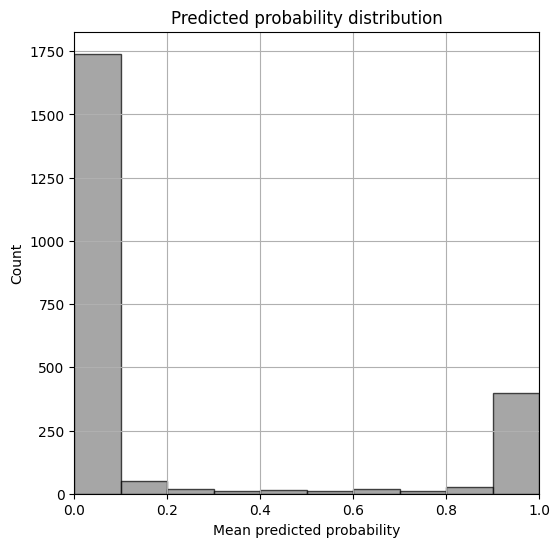

In [20]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

In [30]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10)
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [2300, 8050]

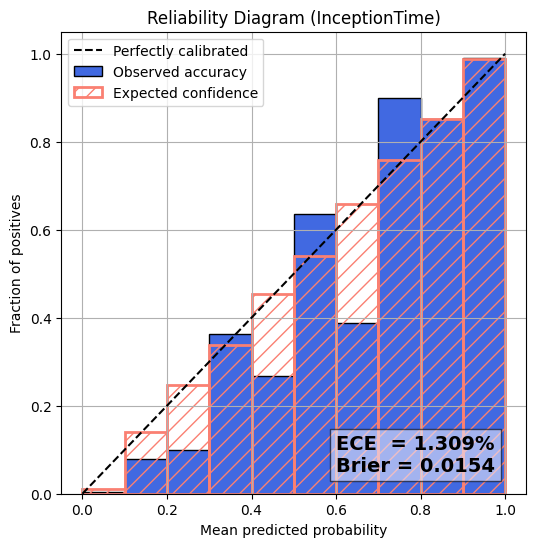

In [38]:
ece = compute_ece(y_test, y_prob_before[:, 1], n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])

# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nBrier = {brier:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [ ]:
from sklearn.isotonic import IsotonicRegression

# Assume you have validation data (X_val, y_val) and their predicted probabilities
p_val = y_prob_before[:, 1]   # model's raw probs before calibration

# Fit isotonic calibration model
iso = IsotonicRegression(out_of_bounds='clip')
p_val_calibrated = iso.fit_transform(p_val, y_val)

# Later, you can apply it to new probabilities
p_test_calibrated = iso.transform(y_prob_after[:, 1])

In [82]:
p_test_calibrated = iso.transform(y_prob_before[:, 1])

In [83]:
p_test_calibrated.shape

(2300,)

### Temperature Scaling

In [81]:
scaled_model = ModelWithTemperature(clf)
scaled_model.set_temperature(X_all[splits[1]], y_all[splits[1]])

Optimal temperature: 0.761


In [84]:
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test_pu, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9886    0.9870    0.9878      1840
           1     0.9482    0.9543    0.9512       460

    accuracy                         0.9804      2300
   macro avg     0.9684    0.9707    0.9695      2300
weighted avg     0.9805    0.9804    0.9805      2300

[[1816   24]
 [  21  439]]


In [92]:
scaled_logits = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits), dim=1).numpy()

In [86]:
ece_before = compute_ece(y_test, y_prob_before[:, 1])
ece_after  = compute_ece(y_test, y_prob_after[:, 1])
print(f"ECE before: {ece_before:.4f}")
print(f"ECE after : {ece_after:.4f}")

ECE before: 0.0131
ECE after : 0.0070


In [56]:
#Optional: find temperature through grid search
logits_val, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = logits_val.argmax(dim=-1)
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9881    0.9924    0.9902       920
           1     0.9690    0.9522    0.9605       230

    accuracy                         0.9843      1150
   macro avg     0.9786    0.9723    0.9754      1150
weighted avg     0.9843    0.9843    0.9843      1150

[[913   7]
 [ 11 219]]


In [90]:
best_T = find_temperature_grid(logits_val, y_val, 200)
# scaled_logits = logits_test / best_T
# y_prob_after = torch.softmax(torch.tensor(scaled_logits), dim=1).numpy()

Best T: 0.7763819095477387, Best ECE: 0.006298085387958136


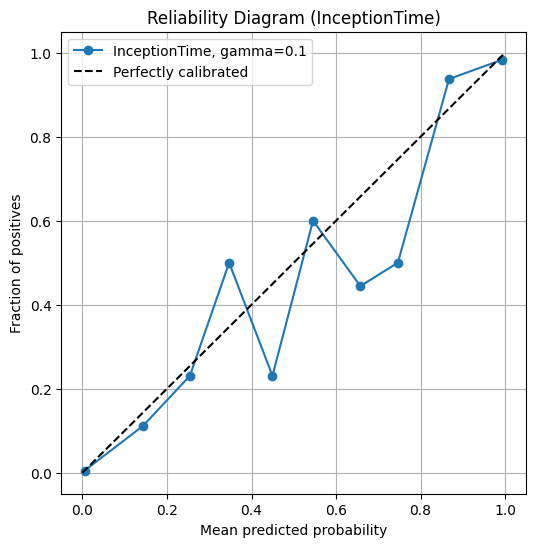

In [93]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10)
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid()
plt.show()

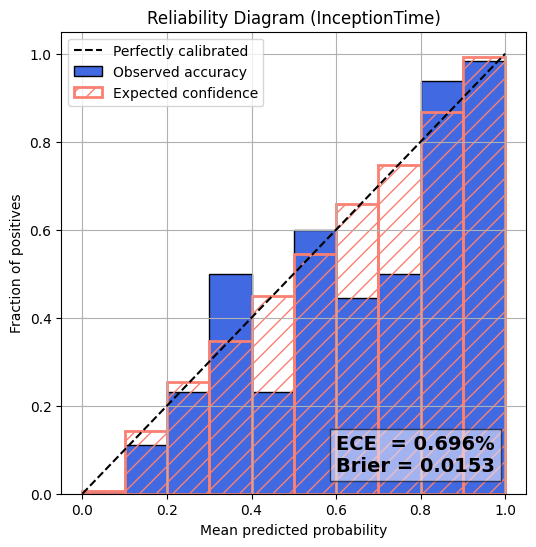

In [94]:
ece = compute_ece(y_test, y_prob_after[:, 1], n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])

# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nBrier = {brier:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [95]:
ece, rows = ece_breakdown(y_test, y_prob_after[:, 1], n_bins=10)
print(f"ECE = {ece:.4f}")
for i, count, conf, acc, diff, contrib in rows:
    print(f"bin {i:2d} | n={count:5d} | conf={conf:6.3f} | acc={acc:6.3f} | "
          f"|acc-conf|={diff:6.3f} | weighted={contrib:7.5f}")


ECE = 0.0070
bin  0 | n= 1778 | conf= 0.005 | acc= 0.005 | |acc-conf|= 0.000 | weighted=0.00005
bin  1 | n=   27 | conf= 0.143 | acc= 0.111 | |acc-conf|= 0.032 | weighted=0.00037
bin  2 | n=   13 | conf= 0.254 | acc= 0.231 | |acc-conf|= 0.023 | weighted=0.00013
bin  3 | n=    6 | conf= 0.347 | acc= 0.500 | |acc-conf|= 0.153 | weighted=0.00040
bin  4 | n=   13 | conf= 0.450 | acc= 0.231 | |acc-conf|= 0.219 | weighted=0.00124
bin  5 | n=   10 | conf= 0.546 | acc= 0.600 | |acc-conf|= 0.054 | weighted=0.00024
bin  6 | n=    9 | conf= 0.657 | acc= 0.444 | |acc-conf|= 0.213 | weighted=0.00083
bin  7 | n=   14 | conf= 0.746 | acc= 0.500 | |acc-conf|= 0.246 | weighted=0.00150
bin  8 | n=   16 | conf= 0.867 | acc= 0.938 | |acc-conf|= 0.070 | weighted=0.00049
bin  9 | n=  414 | conf= 0.993 | acc= 0.983 | |acc-conf|= 0.009 | weighted=0.00170


[0.00513222 0.14287251 0.25419518 0.34709886 0.44954102 0.54550769
 0.65745476 0.7462253  0.86727319 0.99255819]
[0.00506187 0.11111111 0.23076923 0.5        0.23076923 0.6
 0.44444444 0.5        0.9375     0.98309179]


### Mamba2

In [29]:
y_prob_before = torch.softmax(torch.tensor(out_test), dim=1).numpy()
n_bins = 10
y_prob_before

NameError: name 'out_test' is not defined

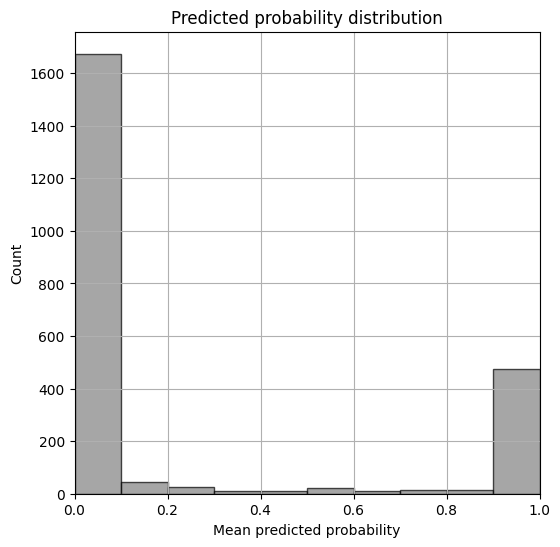

In [35]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

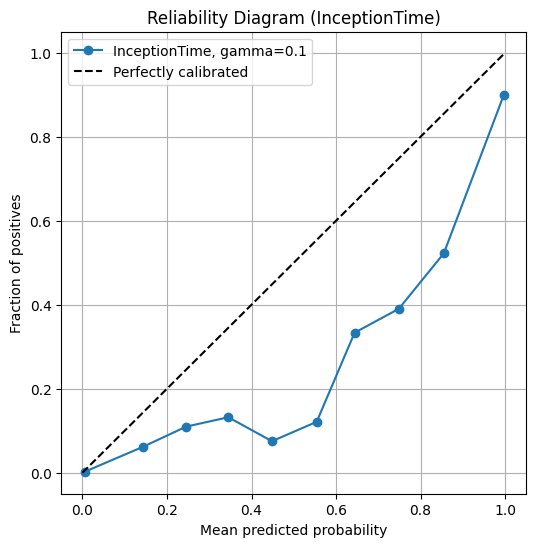

In [28]:
prob_true, prob_pred = calibration_curve(y_train, y_prob_before[:, 1], n_bins=10)
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid()
plt.show()

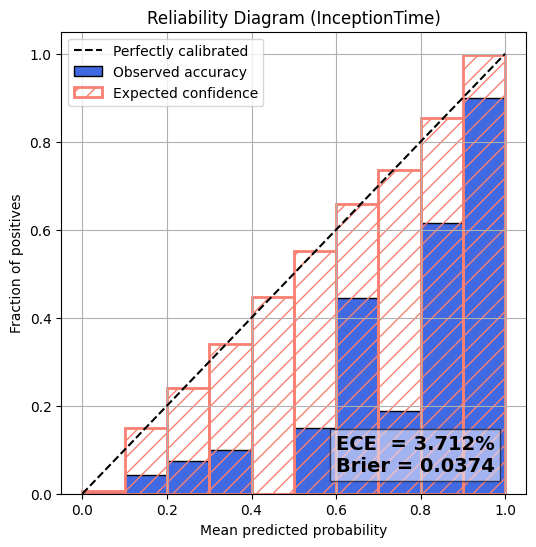

In [39]:
ece = compute_ece(y_test, y_prob_before[:, 1], n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])

# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nBrier = {brier:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [46]:
#Optional: find temperature through grid search
best_T = find_temperature_grid(out_val, y_val, 200)

Best T: 0.9522613065326633, Best ECE: 0.030274142994666874


In [43]:
out_val[:, 1]

tensor([-3.5149, -3.4032, -2.5568,  ..., 10.9903, 10.7047, -4.1850])

In [50]:
from sklearn.isotonic import IsotonicRegression

# Assume you have validation data (X_val, y_val) and their predicted probabilities
p_val = torch.softmax(out_val.clone().detach(), dim=1).numpy()[:, 1]   # model's raw probs before calibration

# Fit isotonic calibration model
iso = IsotonicRegression(out_of_bounds='clip')
p_val_calibrated = iso.fit_transform(p_val, y_val)

# Later, you can apply it to new probabilities
p_test_calibrated = iso.transform(y_prob_before[:, 1])

In [62]:
ece = compute_ece(y_test, y_probs_after[:, 1], n_bins=10)
ece

NameError: name 'y_probs_after' is not defined

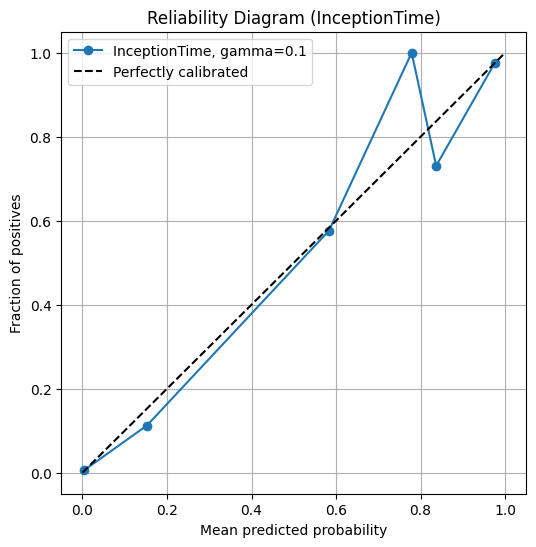

In [54]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated, n_bins=10)
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid()
plt.show()

In [59]:
scaled_model = ModelWithTemperature(model_mamba)
scaled_model.set_temperature(out_val, torch.tensor(y_val, dtype=torch.long))

Optimal temperature: 1.901


ModelWithTemperature(
  (model): Mamba2Classifier(
    (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blocks): Sequential(
      (0): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=512, out_features=256, bias=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): R

In [60]:
scaled_logits = scaled_model.temperature_scale(out_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits), dim=1).numpy()

/tmp/ipykernel_3673442/1464503483.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_prob_after = torch.softmax(torch.tensor(scaled_logits), dim=1).numpy()


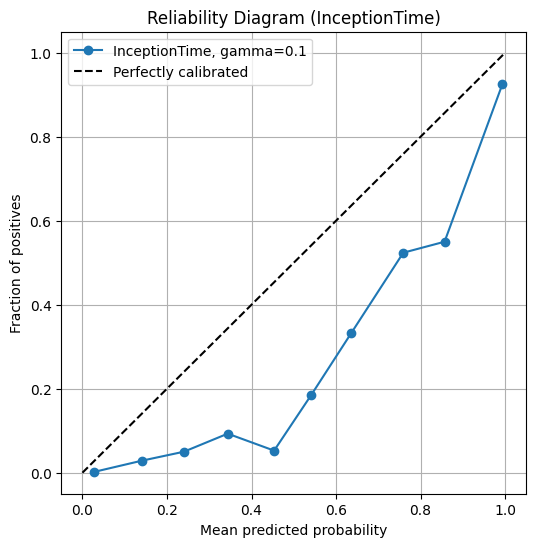

In [61]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10)
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid()
plt.show()